<a href="https://colab.research.google.com/github/saanvib/humwiz/blob/main/Audio_Pitch_Detection_with_new_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
#@title
!pip install --upgrade tensorflow
!pip install essentia

In [4]:
!python setup.py install

python3: can't open file '/content/setup.py': [Errno 2] No such file or directory


Saving UC San Di.wav to UC San Di.wav


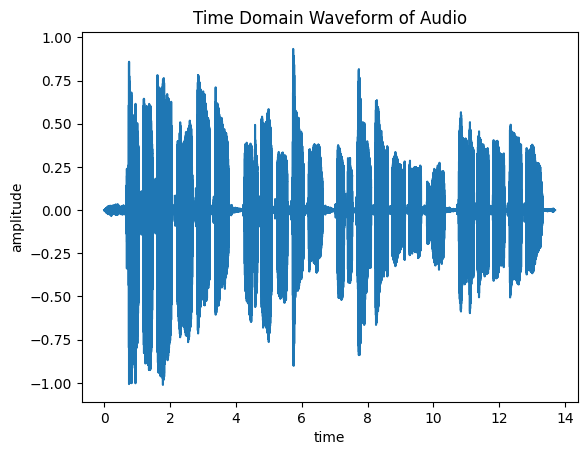

In [5]:
from scipy.io import wavfile
from google.colab import files
import numpy as np
import essentia
import essentia.standard as ess
import matplotlib.pyplot as pyp
import IPython.display as ipd
import matplotlib
import os

def genAudioTone(pitch, hopSize = 128, fs = 44100):
    """
    Generates pure sine tone audio data from the pitch contour

    Parameters
    ----------
    pitch : list
        pitch contour data as a list

    Returns
    -------
    x : np.array
        audio data to play or write wav files

    """
    x = np.array([])
    phase = 0.0

    for frame_no in range(len(pitch)):
        tone = 1.0 * np.cos((2*np.pi*pitch[frame_no]*np.arange(hopSize)/44100) + phase)
        x = np.append(x, tone)
        phase = phase + 2*np.pi*pitch[frame_no]*(hopSize-1)/fs

    return x
uploaded = files.upload()
filen = list(uploaded.keys())[0]
# time, frequency, confidence, activation = crepe.predict(audio, sr, viterbi=True)

Fs = 44100
audio1 = ess.MonoLoader(sampleRate = Fs,filename = filen)()
ipd.Audio(audio1, rate=Fs)

pyp.figure()
pyp.title('Time Domain Waveform of Audio')
pyp.xlabel('time')
pyp.ylabel('amplitude')
t = np.arange(len(audio1))*1.0/Fs
pyp.plot(t,audio1);

Text(0, 0.5, 'frequency')

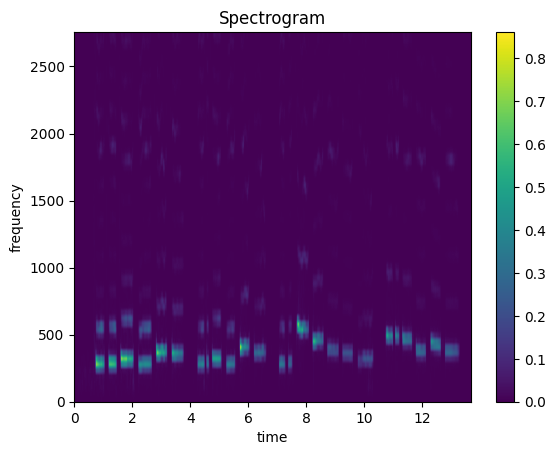

In [19]:
W = 1024
H = 512
w = ess.Windowing(type = 'hann')
fft = ess.FFT()
c2p = ess.CartesianToPolar()
pool = essentia.Pool()
acf = ess.AutoCorrelation()

for frame in ess.FrameGenerator(audio1, frameSize = W, hopSize = H):
    mag, phase, = c2p(fft(w(frame)))
    autocorr = acf(w(frame))
    pool.add('mag_spec', mag)
    pool.add('phase_spec', phase)
    pool.add('acf',autocorr)
freq = np.arange((int)(W/2) + 1)*(Fs/W)
t = np.arange(len(pool['mag_spec']))*(len(audio1)/Fs)/(len(pool['mag_spec']))
pyp.imshow(pool['mag_spec'][:,0:64].T,origin = 'lower',aspect='auto',extent=[t[0],t[-1], freq[0],freq[64]])
pyp.colorbar()
pyp.title('Spectrogram')
pyp.xlabel('time')
pyp.ylabel('frequency')

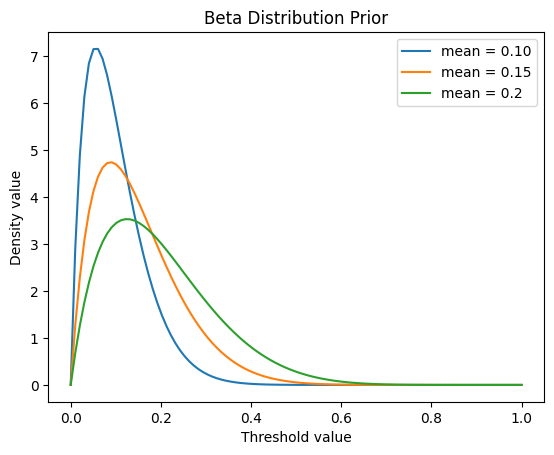

In [20]:
from scipy.stats import beta
a, b = 2.30984964515, 0.62687954301
rv1 = beta(2, 18)
rv2 = beta(2,11.33)
rv3 = beta(2,8)
x = np.linspace(0,1,100)
pyp.figure()
pyp.plot(x,rv1.pdf(x),label = 'mean = 0.10')
pyp.plot(x,rv2.pdf(x),label = 'mean = 0.15')
pyp.plot(x,rv3.pdf(x),label = 'mean = 0.2')
pyp.legend(loc = 'best')
pyp.title('Beta Distribution Prior')
pyp.xlabel('Threshold value')
pyp.ylabel('Density value');

[294.00436, 279.57275, 267.10428, 268.91336, 267.89523, 267.1944, 266.6345, 264.28168, 264.46533, 261.83463, 261.94272, 261.9544, 263.21176, 264.65228, 265.5641, 267.59116, 267.48853, 266.9639, 267.48288, 267.21402, 265.88068, 265.37527, 265.3751, 266.33652, 268.79974, 270.18713, 273.04532, 268.42987, 264.88266, 269.33914, 291.31445, 273.94348, 272.29672, 272.5453, 271.47104, 269.93964, 270.5668, 268.85397, 269.06674, 269.2137, 268.93753, 269.85358, 270.86905, 270.9143, 270.4378, 269.83014, 269.61987, 269.43048, 268.78665, 267.72073, 267.3487, 266.85614, 266.57587, 264.97263, 305.11624, 300.3876, 300.2358, 298.33813, 296.52765, 297.26343, 296.2772, 295.83188, 294.58792, 294.81207, 295.4349, 295.0727, 295.8266, 296.27118, 297.0768, 296.48453, 296.17203, 297.3324, 297.15738, 296.0185, 297.46902, 297.76257, 297.58365, 297.45166, 298.21634, 298.15662, 297.45737, 297.65405, 295.82434, 295.21725, 293.54178, 292.57806, 293.24893, 296.684, 301.8006, 302.90686, 305.82965, 269.89346, 256.41055, 

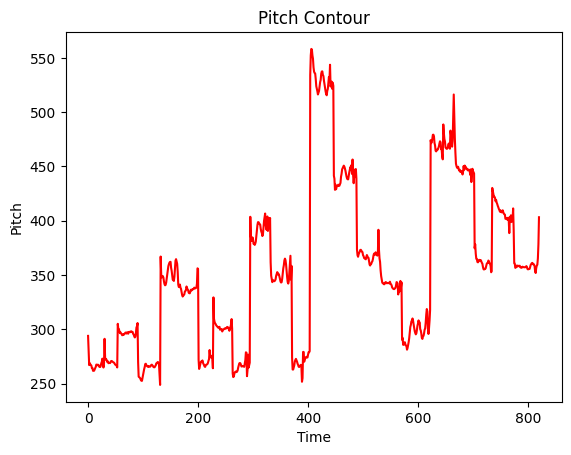

In [32]:
# PYin using essentia
pyin = ess.PitchYinProbabilistic(frameSize = W,hopSize = H,lowRMSThreshold = 0.0001,preciseTime = True)
pyin_p,vp = pyin(audio1)

pyp.figure()
pyp.plot(pyin_p[pyin_p>0],color = 'r')
# print(pyin_p)
# for i in range(len(pyin_p)):
#   print(pyin_p[i])

sorted_pitch = []
for pitch in pyin_p:
  if (pitch > 0):
    sorted_pitch.append(pitch)

print(sorted_pitch)
print(len(sorted_pitch))
pyp.title('Pitch Contour')
pyp.xlabel('Time')
pyp.ylabel('Pitch');

In [37]:
import math
# convert hz to notes
def quantize_predictions(ideal_offset, freq):
    h = round(12 * math.log2(freq / C0))
    # test cases outside
    # h = round(12 * math.log2(freq / C0) - ideal_offset)
    octave = h // 12
    n = h % 12
    note = note_names[n] + str(octave)
    return note


A4 = 440
C0 = A4 * pow(2, -4.75)
note_names = ["C", "C#", "D", "D#", "E", "F", "F#", "G", "G#", "A", "A#", "B"]
note_list = []
def getNotesFromArray(uploaded_file_name):
    pitch_outputs = []
    for i in range(len(uploaded_file_name)):
        pitch_outputs.append(uploaded_file_name[i])
    # offsets = [hz2offset(p) for p in pitch_outputs if p != 0]
    # print("offsets: ", offsets)
    # ideal_offset = statistics.mean(offsets)
    # print("ideal offset: ", ideal_offset)
    for i in range(len(pitch_outputs)):
        ideal_offset = 0
        note_list.append(quantize_predictions(ideal_offset, pitch_outputs[i]))
        # note_list.append(quantize_predictions(ideal_offset, pitch_outputs[i]))
    i = 1
    while i < len(note_list):
      if (note_list[i] == note_list[i-1]):
        del note_list[i]
      else:
        i+=1
    print(note_list)
    # print(note_list)

getNotesFromArray(sorted_pitch)

['D4', 'C#4', 'C4', 'C#4', 'C4', 'C#4', 'D4', 'C#4', 'C4', 'C#4', 'C4', 'D#4', 'D4', 'D#4', 'C#4', 'C4', 'B3', 'C4', 'C#4', 'C4', 'B3', 'F#4', 'F4', 'F#4', 'F4', 'F#4', 'F4', 'E4', 'F4', 'E4', 'F4', 'E4', 'F4', 'C#4', 'C4', 'C#4', 'C4', 'C#4', 'C4', 'E4', 'D#4', 'D4', 'D#4', 'D4', 'D#4', 'D4', 'D#4', 'D4', 'C4', 'C#4', 'C4', 'C#4', 'C4', 'C#4', 'G#4', 'G4', 'F#4', 'G4', 'G#4', 'G4', 'G#4', 'G4', 'F#4', 'F4', 'F#4', 'F4', 'F#4', 'F4', 'C#4', 'C4', 'C#4', 'C4', 'B3', 'C4', 'C#4', 'C5', 'C#5', 'C5', 'C#5', 'C5', 'A4', 'A#4', 'A4', 'F#4', 'F4', 'F#4', 'G4', 'F#4', 'F4', 'E4', 'F4', 'E4', 'F4', 'E4', 'F4', 'D4', 'C#4', 'D4', 'D#4', 'D4', 'D#4', 'D4', 'D#4', 'D4', 'D#4', 'A#4', 'B4', 'A#4', 'B4', 'A#4', 'B4', 'C5', 'B4', 'A#4', 'A4', 'F#4', 'F4', 'F#4', 'F4', 'A4', 'G#4', 'G4', 'G#4', 'G4', 'G#4', 'G4', 'F#4', 'F4', 'F#4', 'F4', 'F#4', 'G4']


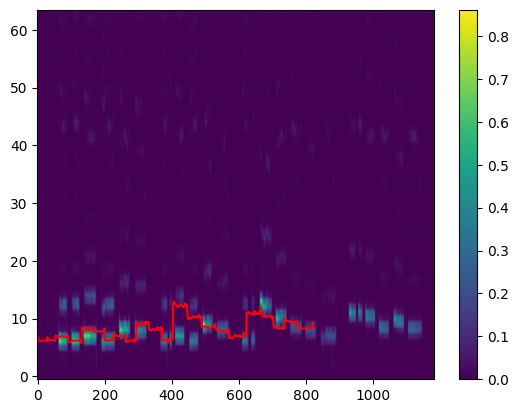

In [38]:
pyp.figure()
pyp.imshow(pool['mag_spec'][:,0:64].T,origin = 'lower',aspect='auto')
pyp.colorbar()
pyp.plot(pyin_p[pyin_p>0]*(W/Fs),color = 'r');
ipd.Audio(genAudioTone(pyin_p[pyin_p>0],H,Fs), rate=Fs)
